# Audio spectrogram

## Background

In this example we will go through the steps to build a DALI audio processing pipeline, including the calculation of a spectrogram. A spectrogram is a representation of a signal (e.g. an audio signal) that shows the evolution of the frequency spectrum in time.

Typically, a spectrogram is calculated by computing the fast fourier transform (FFT) over a series of overlapping windows extracted from the original signal. The process of dividing the signal in short term sequences of fixed size and applying FFT on those independently is called Short-time Fourier transform (STFT). The spectrogram is then calculated as the (typically squared) complex magnitude of the STFT.

Extracting short term windows of the original image affects the calculated spectrum by producing aliasing artifacts. This is often called spectral leakage. To control/reduce the spectral leakage effect, we use different window functions when extracting the windows. Some examples of window functions are: Hann, Hanning, etc.

It is beyond the scope of this example to go deeper into the details of the signal processing concepts we mentioned above. More information can be found here:
- [STFT](https://en.wikipedia.org/wiki/Short-time_Fourier_transform)
- [Window functions](https://en.wikipedia.org/wiki/Window_function)

## Reference implementation

To verify the correctness of DALI's implementation, we will compare it against librosa (https://librosa.github.io/librosa/).

In [1]:
import librosa as librosa
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import librosa.display

Librosa provides an API to calculate the STFT, producing a complex output (i.e. complex numbers). It is then trivial to calculate the power spectrum from the complex STFT by the following

In [2]:
# Size of the FFT, which will also be used as the window length
n_fft=2048

# Step or stride between windows. If the step is smaller than the window lenght, the windows will overlap
hop_length=512

# Load sample audio file
y, sr = librosa.load(librosa.util.example_audio_file())

# Calculate the spectrogram as the square of the complex magnitude of the STFT
spectrogram_librosa = np.abs(librosa.stft(
    y, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window='hann')) ** 2

We can now transform the spectrogram output to a logarithmic scale by transforming the amplitude to decibels. While doing so we will also normalize the spectrogram so that its maximum represent the 0 dB point.

In [3]:
spectrogram_librosa_db = librosa.power_to_db(spectrogram_librosa, ref=np.max)

The last step is to display the spectrogram

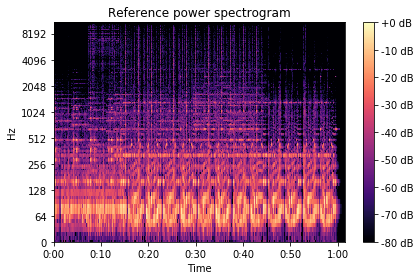

In [4]:
def show_spectrogram(spec, title, sr, hop_length, y_axis='log', x_axis='time'):
    librosa.display.specshow(spec, sr=sr, y_axis=y_axis, x_axis=x_axis, hop_length=hop_length)
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()
    
show_spectrogram(spectrogram_librosa_db, 'Reference power spectrogram', sr, hop_length)

## Calculating the Spectrogram using DALI

To demonstrate DALI's [spectrogram](../../supported_ops.html#nvidia.dali.fn.spectrogram) operator we will define a DALI pipeline, whose input will be provided externally with the help of [external_source](../../supported_ops.html#nvidia.dali.fn.external_source) operator. For demonstration purposes, we can just feed the same input in every iteration, as we will be only calculating one spectrogram.

In [5]:
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import nvidia.dali as dali

audio_data = np.array(y, dtype=np.float32)

@pipeline_def
def spectrogram_pipe(nfft, window_length, window_step, device='cpu'):
    audio = types.Constant(device=device, value=audio_data)
    spectrogram = fn.spectrogram(audio, device=device, nfft=nfft, 
                                 window_length=window_length,
                                 window_step=window_step)
    return spectrogram

With the pipeline defined, we can now just build it and run it

In [6]:
pipe = spectrogram_pipe(device='gpu', batch_size=1, num_threads=3, device_id=0, 
                        nfft=n_fft, window_length=n_fft, window_step=hop_length)
pipe.build()
outputs = pipe.run()
spectrogram_dali = outputs[0][0].as_cpu()

and display it as we did with the reference implementation

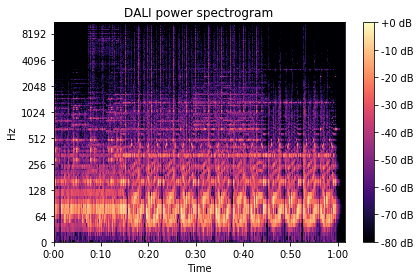

In [7]:
spectrogram_dali_db = librosa.power_to_db(spectrogram_dali, ref=np.max)
show_spectrogram(spectrogram_dali_db, 'DALI power spectrogram', sr, hop_length)

As a last sanity check, we can verify that the numerical difference between the reference implementation and DALI's is insignificant

In [8]:
print("Average error: {0:.5f} dB".format(np.mean(np.abs(spectrogram_dali_db - spectrogram_librosa_db))))
assert(np.allclose(spectrogram_dali_db, spectrogram_librosa_db, atol=2))

Average error: 0.00359 dB


## Mel Spectrogram

The mel scale is a non-linear transformation of frequency scale based on the perception of pitches. The mel scale is calculated so that two pairs of frequencies separated by a delta in the mel scale are perceived by humans as being equidistant. More information can be found here: https://en.wikipedia.org/wiki/Mel_scale.

In machine learning applications involving speech and audio, we typically want to represent the power spectrogram in the mel scale domain. We do that by applying a bank of overlapping triangular filters that compute the energy of the spectrum in each band.

Typically, we want the mel spectrogram represented in decibels. We can calculate a mel spectrogram in decibels by using the following DALI pipeline. 

In [9]:
@pipeline_def
def mel_spectrogram_pipe(nfft, window_length, window_step, device='cpu'):
    audio = types.Constant(device=device, value=audio_data)
    spectrogram = fn.spectrogram(audio, device=device, nfft=nfft, 
                                 window_length=window_length,
                                 window_step=window_step)
    mel_spectrogram = fn.mel_filter_bank(spectrogram, sample_rate=sr, nfilter = 128, freq_high = 8000.0)
    mel_spectrogram_dB = fn.to_decibels(mel_spectrogram, multiplier = 10.0, cutoff_db = -80)
    return mel_spectrogram_dB

In [10]:
pipe = mel_spectrogram_pipe(device='gpu', batch_size=1, num_threads=3, device_id=0,
                            nfft=n_fft, window_length=n_fft, window_step=hop_length)
pipe.build()
outputs = pipe.run()
mel_spectrogram_dali_db = np.array(outputs[0][0].as_cpu())

We can now verify that it produces the same result as Librosa

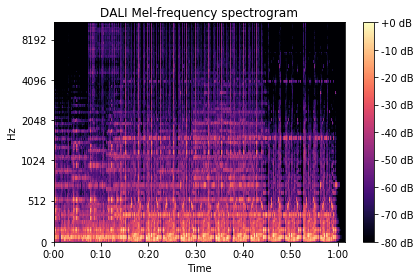

In [11]:
show_spectrogram(mel_spectrogram_dali_db, 'DALI Mel-frequency spectrogram', sr, hop_length, y_axis='mel')

In [12]:
mel_spectrogram_librosa = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
mel_spectrogram_librosa_db = librosa.power_to_db(mel_spectrogram_librosa, ref=np.max)
assert(np.allclose(mel_spectrogram_dali_db, mel_spectrogram_librosa_db, atol=1))

## Mel-Frequency Cepstral Coefficients (MFCCs)

MFCCs are an alternative representation of the Mel-frequency spectrogram often used in audio applications. The MFCCs are calculated by applying the discrete cosine transform (DCT) to a mel-frequency spectrogram. 

DALI's implementation of DCT uses uses the formulas described in https://en.wikipedia.org/wiki/Discrete_cosine_transform


In addition to the DCT, a cepstral filter (also known as *liftering*) can be applied to emphasize higher order coefficients.

A *liftered* cepstral coefficient is calculated according to the formula
$$
\widehat{\text{MFCC}_i} = w_{i} \cdot \text{MFCC}_{i}
$$
where
$$
w_i = 1 + \frac{L}{2}\sin\Big(\frac{\pi i}{L}\Big)
$$
where $L$ is the *liftering* coefficient.

More information about MFCC can be found here: https://en.wikipedia.org/wiki/Mel-frequency_cepstrum.

We can use DALI's MFCC operator to transform the mel-spectrogram into a set of MFCCs

In [21]:
@pipeline_def
def mel_spectrogram_pipe(nfft, window_length, window_step, dct_type, n_mfcc, normalize, lifter, device='cpu'):
    audio = types.Constant(device=device, value=audio_data)
    spectrogram = fn.spectrogram(audio, device=device, nfft=nfft, 
                                 window_length=window_length,
                                 window_step=window_step)
    mel_spectrogram = fn.mel_filter_bank(spectrogram, sample_rate=sr, nfilter = 128, freq_high = 8000.0)
    mel_spectrogram_dB = fn.to_decibels(mel_spectrogram, multiplier = 10.0, cutoff_db = -80)
    mfccs = fn.mfcc(mel_spectrogram_dB, axis=0,dct_type=2, n_mfcc=20, 
                         )
    return mfccs

Let's now run the pipeline and display the output as we did previously

In [22]:
pipe = mel_spectrogram_pipe(device='gpu', batch_size=1, num_threads=3, device_id=0,
                            nfft=n_fft, window_length=n_fft, window_step=hop_length,
                            dct_type=2, n_mfcc=20, normalize=True, lifter=0)
pipe.build()
outputs = pipe.run()
mfccs_dali = np.array(outputs[0][0].as_cpu())

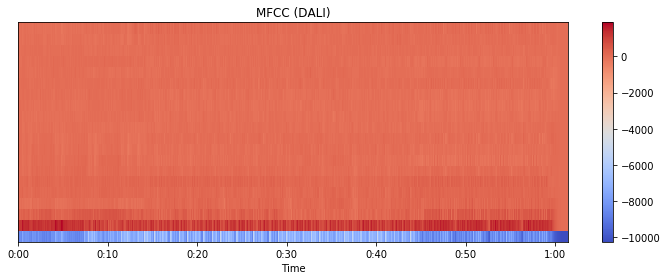

In [23]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs_dali, x_axis='time')
plt.colorbar()
plt.title('MFCC (DALI)')
plt.tight_layout()
plt.show()

As a last step, let's verify that this implementation produces the same result as Librosa. Please note, we are comparing the ortho-normalized MFCCs, as Librosa's DCT implementation uses a different formula which causes the output to be scaled by a factor of 2 when we compare it with the Wikipedia's formulae. 

In [16]:
mfccs_librosa = librosa.feature.mfcc(S=mel_spectrogram_librosa_db,
                                     dct_type=2, n_mfcc=40, norm='ortho', lifter=0)
assert(np.allclose(mfccs_librosa, mfccs_dali, atol=1))

ValueError: operands could not be broadcast together with shapes (40,2647) (20,2647) 